---


Датасет: [ADDI project](https://www.fc.up.pt/addi/ph2%20database.html).

<table><tr><td>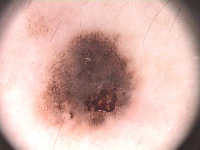</td><td>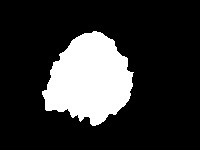</td></tr></table>


Это фотографии двух типов **поражений кожи:** меланома и родинки.

In [ ]:
checkpoint = {}
test_score = {}

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
!gdown https://drive.google.com/uc?id=1D5kZvea81dGRnmCXXolNJ4TL-MDksti7 -O PH2Dataset.rar

Downloading...
From: https://drive.google.com/uc?id=1D5kZvea81dGRnmCXXolNJ4TL-MDksti7
To: /content/PH2Dataset.rar
100% 116M/116M [00:00<00:00, 125MB/s]


In [ ]:
get_ipython().system_raw("unrar x PH2Dataset.rar")

Стуктура датасета у нас следующая:

    IMD_002/
        IMD002_Dermoscopic_Image/
            IMD002.bmp
        IMD002_lesion/
            IMD002_lesion.bmp
        IMD002_roi/
            ...
    IMD_003/
        ...
        ...

 Здесь `X.bmp` — изображение, которое нужно сегментировать, `X_lesion.bmp` — результат сегментации.

Для загрузки датасета можно использовать skimage: [`skimage.io.imread()`](https://scikit-image.org/docs/dev/api/skimage.io.html)

In [ ]:
images = []
lesions = []
from skimage.io import imread
import os
root = 'PH2Dataset'

for root, dirs, files in os.walk(os.path.join(root, 'PH2 Dataset images')):
    if root.endswith('_Dermoscopic_Image'):
        images.append(imread(os.path.join(root, files[0])))
    if root.endswith('_lesion'):
        lesions.append(imread(os.path.join(root, files[0])))

Изображения имеют разные размеры. Изменим их размер на $256\times256 $ пикселей. 

In [ ]:
from skimage.transform import resize
size = (256, 256)
X = [resize(x, size, mode='constant', anti_aliasing=True,) for x in images]
Y = [resize(y, size, mode='constant', anti_aliasing=False) > 0.5 for y in lesions]

In [ ]:
import numpy as np
X = np.array(X, np.float32)
Y = np.array(Y, np.float32)
print(f'Loaded {len(X)} images')

Loaded 200 images


In [ ]:
len(lesions)

200

Чтобы убедиться, что все корректно, мы нарисуем несколько изображений

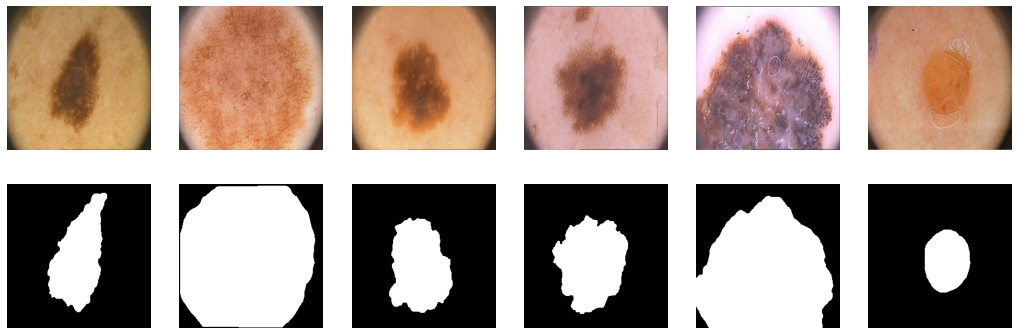

In [ ]:
import matplotlib.pyplot as plt
from IPython.display import clear_output

plt.figure(figsize=(18, 6))
for i in range(6):
    plt.subplot(2, 6, i+1)
    plt.axis("off")
    plt.imshow(X[i])

    plt.subplot(2, 6, i+7)
    plt.axis("off")
    plt.imshow(Y[i], cmap='gray')
plt.show();

Разделим наши 200 картинок на 100/50/50
 для обучения, валидации и теста соответственно

In [ ]:
ix = np.random.choice(len(X), len(X), False)
tr, val, ts = np.split(ix, [100, 150])

In [ ]:
print(len(tr), len(val), len(ts))

100 50 50


#### PyTorch DataLoader

In [ ]:
from torch.utils.data import DataLoader
batch_size = 10
data_tr = DataLoader(list(zip(np.rollaxis(X[tr], 3, 1), Y[tr, np.newaxis])), 
                     batch_size=batch_size, shuffle=True)
data_val = DataLoader(list(zip(np.rollaxis(X[val], 3, 1), Y[val, np.newaxis])),
                      batch_size=batch_size, shuffle=True)
data_ts = DataLoader(list(zip(np.rollaxis(X[ts], 3, 1), Y[ts, np.newaxis])),
                     batch_size=batch_size, shuffle=True)

In [ ]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


# Реализация различных архитектур:
Ваше задание будет состоять в том, чтобы написать несколько нейросетевых архитектур для решения задачи семантической сегментации. Сравнить их по качеству на тесте и испробовать различные лосс функции для них.

-----------------------------------------------------------------------------------------

# SegNet

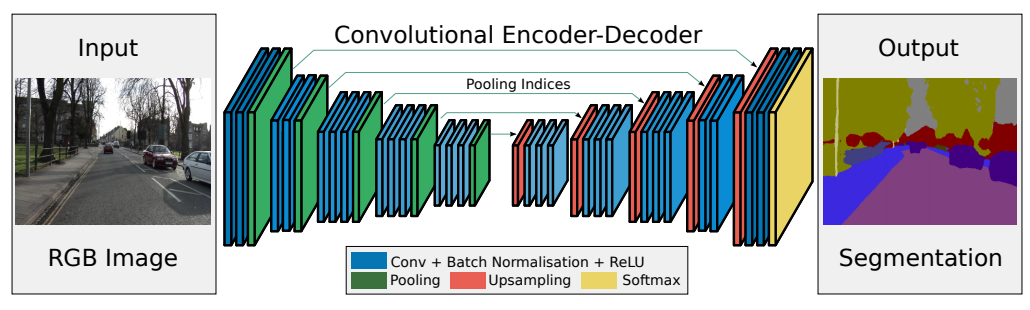

* Badrinarayanan, V., Kendall, A., & Cipolla, R. (2015). [SegNet: A deep convolutional
encoder-decoder architecture for image segmentation](https://arxiv.org/pdf/1511.00561.pdf)

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
import torch.optim as optim
from time import time

import matplotlib.pyplot as plt
from matplotlib import rcParams
rcParams['figure.figsize'] = (23, 4)

In [ ]:
class SegNet(nn.Module):
    def __init__(self):
        super().__init__()

       
        self.enc_conv0 = nn.Sequential(nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
                                       nn.ReLU(),
                                       nn.BatchNorm2d(64),
                                       nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
                                       nn.ReLU(),
                                       nn.BatchNorm2d(64)                                       
        )

        self.pool0 = nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True) # 256 -> 128

        self.enc_conv1 = nn.Sequential(nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
                                       nn.ReLU(),
                                       nn.BatchNorm2d(128),
                                       nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
                                       nn.ReLU(),
                                       nn.BatchNorm2d(128)
        )

        self.pool1 =  nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True) # 128 -> 64

        self.enc_conv2 = nn.Sequential(nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
                                       nn.ReLU(),
                                       nn.BatchNorm2d(256),
                                       nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
                                       nn.ReLU(),
                                       nn.BatchNorm2d(256),
                                       nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
                                       nn.ReLU(),
                                       nn.BatchNorm2d(256)
        )

        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True) # 64 -> 32

        self.enc_conv3 = nn.Sequential(nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
                                       nn.ReLU(),
                                       nn.BatchNorm2d(512),
                                       nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
                                       nn.ReLU(),
                                       nn.BatchNorm2d(512),
                                       nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
                                       nn.ReLU(),
                                       nn.BatchNorm2d(512)
        )

        self.pool3 =  nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True) # 32 -> 16

        
        # bottleneck
        self.bottleneck_conv = nn.Sequential(nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
                                             nn.ReLU(),
                                             nn.BatchNorm2d(512),
                                             nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
                                             nn.ReLU(),
                                             nn.BatchNorm2d(512),
                                             nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1)
            
        )

        

        # decoder (upsampling)
        
        self.upsample0 = nn.MaxUnpool2d(kernel_size=2, stride=2) # 16 -> 32

        self.dec_conv0 = nn.Sequential(nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
                                       nn.ReLU(),
                                       nn.BatchNorm2d(512),
                                       nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
                                       nn.ReLU(),
                                       nn.BatchNorm2d(512),
                                       nn.Conv2d(512, 256, kernel_size=3, stride=1, padding=1),
                                       nn.ReLU(),
                                       nn.BatchNorm2d(256)
        )

        self.upsample1 = nn.MaxUnpool2d(kernel_size=2, stride=2) # 32 -> 64
                                        
        self.dec_conv1 = nn.Sequential(nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
                                       nn.ReLU(),
                                       nn.BatchNorm2d(256),
                                       nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
                                       nn.ReLU(),
                                       nn.BatchNorm2d(256),
                                       nn.Conv2d(256, 128, kernel_size=3, stride=1, padding=1),
                                       nn.ReLU(),
                                       nn.BatchNorm2d(128)
        )


        self.upsample2 = nn.MaxUnpool2d(kernel_size=2, stride=2)  # 64 -> 128
                                        
        self.dec_conv2 = nn.Sequential(nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
                                       nn.ReLU(),
                                       nn.BatchNorm2d(128),
                                       nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
                                       nn.ReLU(),
                                       nn.BatchNorm2d(128),
                                       nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1),
                                       nn.ReLU(),
                                       nn.BatchNorm2d(64)
        )


        self.upsample3 =  nn.MaxUnpool2d(kernel_size=2, stride=2) # 128 -> 256

        self.dec_conv3 = nn.Sequential(nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
                                       nn.ReLU(),
                                       nn.BatchNorm2d(64),
                                       nn.Conv2d(64, 1, kernel_size=3, stride=1, padding=1)                                    
        )

    def forward(self, x):
        # encoder
        e0 = self.enc_conv0(x)
        e0, indices0 = self.pool0(e0)        
        e1 = self.enc_conv1(e0)
        e1, indices1 = self.pool1(e1)
        e2 = self.enc_conv2(e1)
        e2, indices2 = self.pool2(e2)
        e3 = self.enc_conv3(e2)
        e3, indices3 = self.pool3(e3)
        
        # bottleneck
        b = self.bottleneck_conv(e3)

        # decoder
        d0 = self.upsample0(b, indices3)
        d0 = self.dec_conv0(d0)
        d1 = self.upsample1(d0, indices2)
        d1 = self.dec_conv1(d1)
        d2 = self.upsample2(d1, indices1)
        d2 = self.dec_conv2(d2)
        d3 = self.upsample3(d2, indices0)
        d3 = self.dec_conv3(d3)  # no activation
        return d3

## Метрика

В данном разделе предлагается использовать следующую метрику для оценки качества:

$I o U=\frac{\text {target } \cap \text { prediction }}{\text {target } \cup{prediction }}$

Пересечение (A ∩ B) состоит из пикселей, найденных как в маске предсказания, так и в основной маске истины, тогда как объединение (A ∪ B) просто состоит из всех пикселей, найденных либо в маске предсказания, либо в целевой маске.


Для примера посмотрим на истину (слева) и предсказание (справа):
![alt text](https://www.jeremyjordan.me/content/images/2018/05/target_prediction.png)


Тогда пересечение и объединение будет выглядеть так:

![alt text](https://www.jeremyjordan.me/content/images/2018/05/intersection_union.png)

In [ ]:
def iou_pytorch(outputs: torch.Tensor, labels: torch.Tensor):
    # You can comment out this line if you are passing tensors of equal shape
    # But if you are passing output from UNet or something it will most probably
    # be with the BATCH x 1 x H x W shape
    outputs = outputs.squeeze(1) > 0.5    # BATCH x 1 x H x W => BATCH x H x W
    labels = labels.squeeze(1).byte()
    SMOOTH = 1e-8
    
    intersection = (outputs & labels).float().sum((1, 2))  # Will be zero if Truth=0 or Prediction=0
    union = (outputs | labels).float().sum((1, 2))         # Will be zero if both are 0
    
    iou = (intersection + SMOOTH) / (union + SMOOTH)  # We smooth our devision to avoid 0/0
    
    thresholded = torch.clamp(20 * (iou - 0.5), 0, 10).ceil() / 10  # This is equal to comparing with thresholds
    
    return thresholded 

## Функция потерь

Не менее важным, чем построение архитектуры, является определение **оптимизатора** и **функции потерь.**

Функция потерь - это то, что мы пытаемся минимизировать. Многие из них могут быть использованы для задачи бинарной семантической сегментации. 

Популярным методом для бинарной сегментации является *бинарная кросс-энтропия*, которая задается следующим образом:

$$\mathcal L_{BCE}(y, \hat y) = -\sum_i \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

где $y$ это  таргет желаемого результата и $\hat y$ является выходом модели. $\sigma$ - это [*логистическая* функция](https://en.wikipedia.org/wiki/Sigmoid_function), который преобразует действительное число $\mathbb R$ в вероятность $[0,1]$.

Однако эта потеря страдает от проблем численной нестабильности. Самое главное, что $\lim_{x\rightarrow0}\log(x)=\infty$ приводит к неустойчивости в процессе оптимизации. Рекомендуется посмотреть следующее [упрощение](https://www.tensorflow.org/api_docs/python/tf/nn/sigmoid_cross_entropy_with_logits). Эта функция эквивалентна первой и не так подвержена численной неустойчивости:

$$\mathcal L_{BCE} = \hat y - y\hat y + \log\left(1+\exp(-\hat y)\right).$$

In [ ]:
def bce_loss(y_real, y_pred):
    loss = y_pred - y_real * y_pred + torch.log(1 + torch.exp(-y_pred))
    return loss.mean()

## Тренировка

Мы определим цикл обучения в функции, чтобы мы могли повторно использовать его.

In [ ]:
def train(model, opt, loss_fn, epochs, data_tr, data_val, scheduler=None):
    train_loss = []
    val_loss = []

    for epoch in range(epochs):
        X_val, Y_val = next(iter(data_val))
        tic = time()
        print('* Epoch %d/%d' % (epoch+1, epochs))

        avg_loss = 0
        model.train()  # train mode
        for X_batch, Y_batch in data_tr:
            # data to device
            X_batch = X_batch.to(device)
            Y_batch = Y_batch.to(device)

            # set parameter gradients to zero
            opt.zero_grad()


            # forward
            Y_pred = model(X_batch)
            loss = loss_fn(Y_batch, Y_pred) # forward-pass
            loss.backward()  # backward-pass
            opt.step()  # update weights

            # calculate loss to show to a user
            avg_loss += loss / len(data_tr)
        toc = time()
        print('loss: %f' % avg_loss)
        train_loss.append(avg_loss.item())

        # show intermediate results
        model.eval()  # testing mode
        X_val = X_val.to(device)
        Y_pr = model(X_val)
        Y_hat = Y_pr.detach().to('cpu') # detach and put into cpu
        X_val = X_val.to('cpu')
        loss_val = loss_fn(Y_val, Y_hat)
        val_loss.append(loss_val.item())


        # Visualize tools
        clear_output(wait=True)
        for k in range(10):
            plt.subplot(2, 10, k+1) 
            plt.imshow(np.rollaxis(X_val[k].numpy(), 0, 3), cmap='gray')
            plt.title('Real')
            plt.axis('off')

            plt.subplot(2, 10, k+11)
            plt.imshow(Y_hat[k, 0], cmap='gray')
            plt.title('Output')
            plt.axis('off')
        plt.suptitle('%d / %d - train_loss: %f, val_loss: %f' % (epoch+1, epochs, avg_loss, loss_val))
        plt.show()
        if scheduler is not None:
            scheduler.step()

    return model, train_loss, val_loss

## Инференс

После обучения модели эту функцию можно использовать для прогнозирования сегментации на новых данных:

In [ ]:
def predict(model, data):
    model.eval()  # testing mode
    Y_pred = [X_batch for X_batch, _ in data]
    return np.array(Y_pred)

In [ ]:
def score_model(model, metric, data):
    model.eval()  # testing mode
    scores = 0
    for X_batch, Y_label in data:
        X_batch = X_batch.to(device)
        Y_label = Y_label.to(device)
        Y_pred = model(X_batch)
        #Y_pred = Y_pred.to(device)
        scores += metric(Y_pred, Y_label).mean().item()

    return scores/len(data)

## Обучение

Обучите вашу модель. Обратите внимание, что обучать необходимо до сходимости. Если указанного количества эпох (20) не хватило, попробуйте изменять количество эпох до сходимости алгоритма. Сходимость определяйте по изменению функции потерь на валидационной выборке.
 С параметрами оптимизатора можно спокойно играть, пока вы не найдете лучший вариант для себя.


In [ ]:
model_segnet = SegNet()

In [ ]:
model_segnet = model_segnet.to(device)

In [ ]:
max_epochs = 50
optim = torch.optim.Adam(model_segnet.parameters(), lr=3e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optim, step_size=20, gamma=0.1)

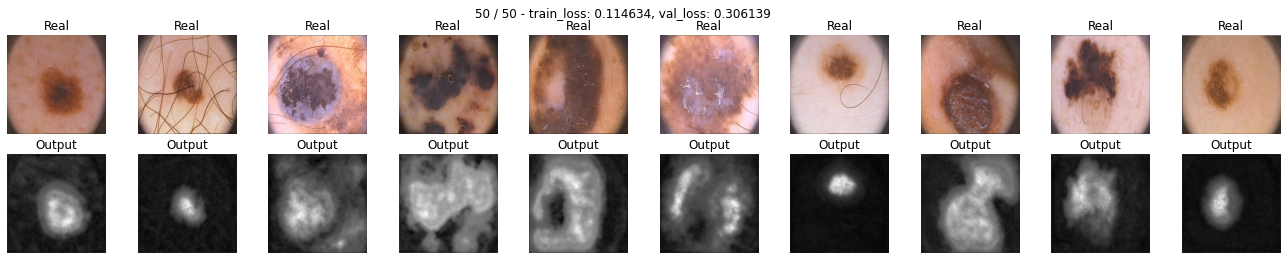

In [ ]:
model_segnet, segnet_bce_train, segnet_bce_val = train(model_segnet, optim, bce_loss, max_epochs, data_tr, data_val, scheduler)

In [ ]:
score_model(model_segnet, iou_pytorch, data_val)

0.7480000257492065

In [ ]:
score_model(model_segnet, iou_pytorch, data_ts)

0.7040000081062316

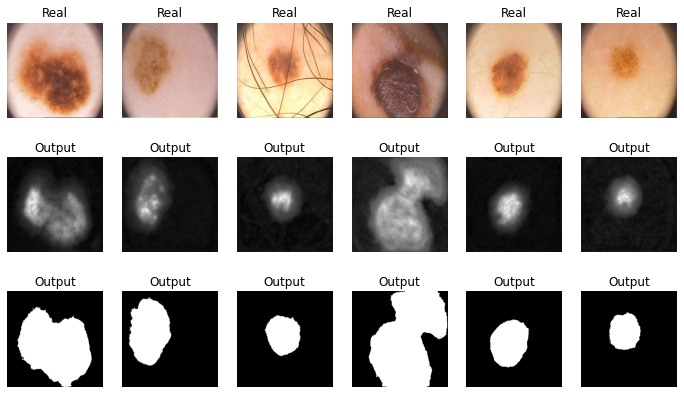

In [ ]:
X_val, Y_val = next(iter(data_val))
model_segnet.to('cpu')

model_segnet.eval()  # testing mode
Y_pred = model_segnet(X_val)
Y_hat = Y_pred.detach().to('cpu') # detach and put into cpu

# Visualize tools
clear_output(wait=True)
plt.figure(figsize=(12,7))
for k in range(6):
    plt.subplot(3, 6, k+1) 
    plt.imshow(np.rollaxis(X_val[k].numpy(), 0, 3), cmap='gray')
    plt.title('Real')
    plt.axis('off')

    plt.subplot(3, 6, k+7)
    plt.imshow(Y_hat[k, 0], cmap='gray')
    plt.title('Output')
    plt.axis('off')

    plt.subplot(3, 6, k+13)
    plt.imshow(torch.sigmoid(Y_hat[k, 0]) > 0.5, cmap='gray')
    plt.title('Output')
    plt.axis('off')

plt.show()

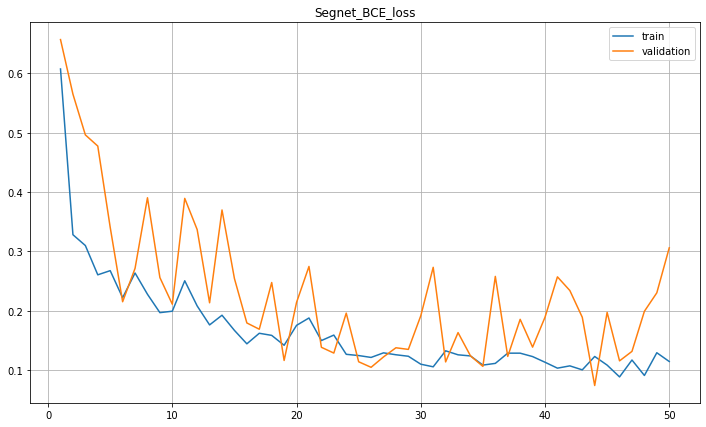

In [ ]:
plt.figure(figsize=(12,7))
plt.plot(range(1, 51), segnet_bce_train, label='train')
plt.plot(range(1, 51), segnet_bce_val, label='validation')
plt.grid()
plt.title('Segnet_BCE_loss')
plt.legend()
plt.show()

In [ ]:
checkpoint['segnet_bce_train'] = segnet_bce_train
checkpoint['segnet_bce_val'] = segnet_bce_val
checkpoint.keys()

dict_keys(['segnet_bce_train', 'segnet_bce_val'])

In [ ]:
test_score['segnet_bce_val'] = score_model(model_segnet, iou_pytorch, data_val)
test_score['segnet_bce_test'] = score_model(model_segnet, iou_pytorch, data_ts)
test_score.keys()

dict_keys(['segnet_bce_val', 'segnet_bce_test'])

In [ ]:
torch.save(checkpoint, 'checkpoint.pth')
torch.save(test_score, 'test_score.pth')

-----------------------------------------------------------------------------------------

## Дополнительные функции потерь

**1. Dice coefficient:** Учитывая две маски $X$ и $Y$, общая метрика для измерения расстояния между этими двумя масками задается следующим образом:

$$D(X,Y)=\frac{2|X\cap Y|}{|X|+|Y|}$$

Эта функция не является дифференцируемой, но это необходимое свойство для градиентного спуска. В данном случае мы можем приблизить его с помощью:

$$\mathcal L_D(X,Y) = 1-\frac{1}{256 \times 256} \times \frac{\sum_i 2X_iY_i}{\sum_i(X_i+Y_i)}.$$

Не забудьте подумать о численной нестабильности, возникающей в математической формуле.


In [ ]:
checkpoint = torch.load('./checkpoint1.pth')
test_score = torch.load('./test_score1.pth')

In [ ]:
def dice_loss(y_true, y_pred):
  y_pred = torch.sigmoid(y_pred)
  numerator = 2 * torch.sum(y_true * y_pred)
  denominator = torch.sum(y_true + y_pred)

  return 1 - numerator / denominator

Проводим тестирование:

In [ ]:
model_dice = SegNet().to(device)

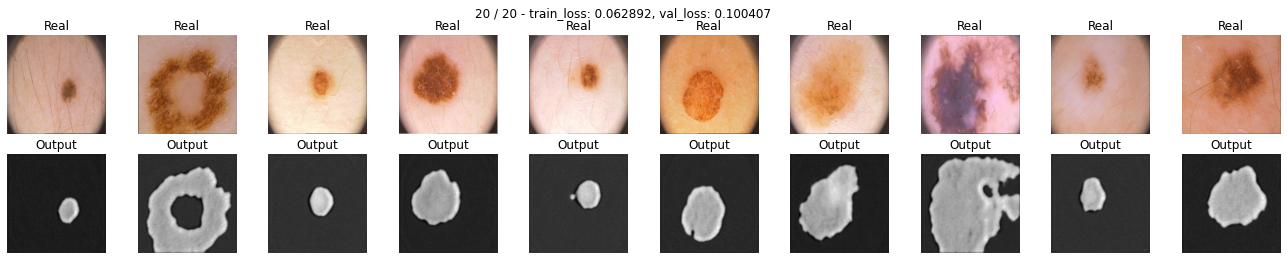

In [ ]:
max_epochs = 20
optimizer = torch.optim.AdamW(model_dice.parameters(), lr=3e-7)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
model_dice, segnet_dice_train, segnet_dice_val = train(model_dice, optimizer, dice_loss, max_epochs, data_tr, data_val, scheduler)

In [ ]:
score_model(model_dice, iou_pytorch, data_val)

0.7480000019073486

In [ ]:
score_model(model_dice, iou_pytorch, data_ts)

0.7540000319480896

In [ ]:
test_score['segnet_dice_val'] = score_model(model_dice, iou_pytorch, data_val)
test_score['segnet_dice_test'] = score_model(model_dice, iou_pytorch, data_ts)
test_score.keys()

dict_keys(['segnet_bce_val', 'segnet_bce_test', 'segnet_dice_val', 'segnet_dice_test'])

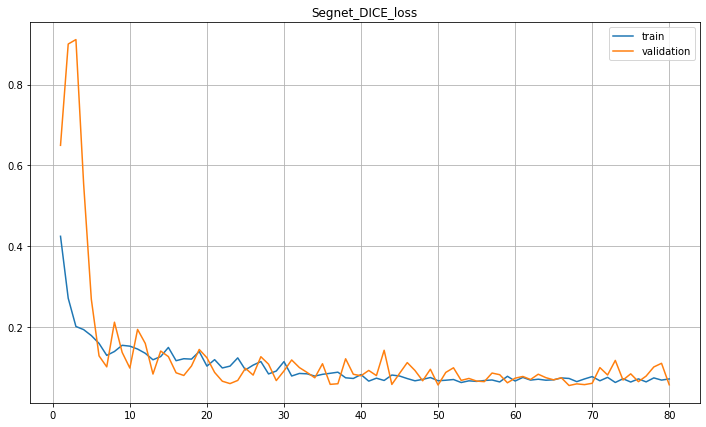

In [ ]:
plt.figure(figsize=(12,7))
plt.plot(range(1, 81), checkpoint['segnet_dice_train'], label='train')
plt.plot(range(1, 81), checkpoint['segnet_dice_val'], label='validation')
plt.grid()
plt.title('Segnet_DICE_loss')
plt.legend()
plt.show()

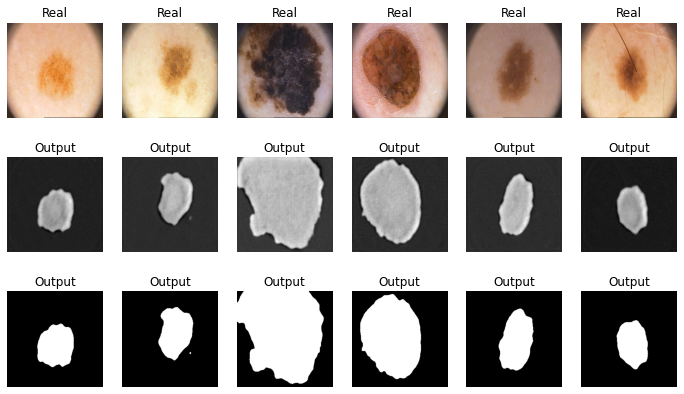

In [ ]:
X_val, Y_val = next(iter(data_val))
model_dice.to('cpu')

model_dice.eval()  # testing mode
Y_pred = model_dice(X_val)
Y_hat = Y_pred.detach().to('cpu') # detached and put into cpu

# Visualize tools
clear_output(wait=True)
plt.figure(figsize=(12,7))
for k in range(6):
    plt.subplot(3, 6, k+1) 
    plt.imshow(np.rollaxis(X_val[k].numpy(), 0, 3), cmap='gray')
    plt.title('Real')
    plt.axis('off')

    plt.subplot(3, 6, k+7)
    plt.imshow(Y_hat[k, 0], cmap='gray')
    plt.title('Output')
    plt.axis('off')

    plt.subplot(3, 6, k+13)
    plt.imshow(torch.sigmoid(Y_hat[k, 0]) > 0.5, cmap='gray')
    plt.title('Output')
    plt.axis('off')

plt.show()

In [ ]:
checkpoint['segnet_dice_train'] = segnet_dice_train
checkpoint['segnet_dice_val'] = segnet_dice_val
checkpoint.keys()

dict_keys(['segnet_bce_train', 'segnet_bce_val', 'segnet_dice_train', 'segnet_dice_val'])

[**2. Focal loss:**](https://arxiv.org/pdf/1708.02002.pdf) 

Окей, мы уже с вами умеем делать BCE loss:

$$\mathcal L_{BCE}(y, \hat y) = -\sum_i \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

Проблема с этой потерей заключается в том, что она имеет тенденцию приносить пользу классу **большинства** (фоновому) по отношению к классу **меньшинства** ( переднему). Поэтому обычно применяются весовые коэффициенты к каждому классу:

$$\mathcal L_{wBCE}(y, \hat y) = -\sum_i \alpha_i\left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

Традиционно вес $\alpha_i$ определяется как обратная частота класса этого пикселя $i$, так что наблюдения миноритарного класса весят больше по отношению к классу большинства.

Еще одним недавним дополнением является взвешенный пиксельный вариант, которая взвешивает каждый пиксель по степени уверенности, которую мы имеем в предсказании этого пикселя.

$$\mathcal L_{focal}(y, \hat y) = -\sum_i \left[\left(1-\sigma(\hat y_i)\right)^\gamma y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

Зафиксируем значение $\gamma=2$.

--------------------------------------------------------------------------------


In [ ]:
def focal_loss(y_real, y_pred, gamma=2):
    
    y_pred = torch.clamp(y_pred, min=0, max=1)
    your_loss = -torch.mean((1 - torch.sigmoid(y_pred))**gamma * y_real * torch.log(torch.sigmoid(y_pred)) + (1 - y_real) * torch.log(1 - torch.sigmoid(y_pred)))

    return your_loss

In [ ]:
model_focal = SegNet().to(device)

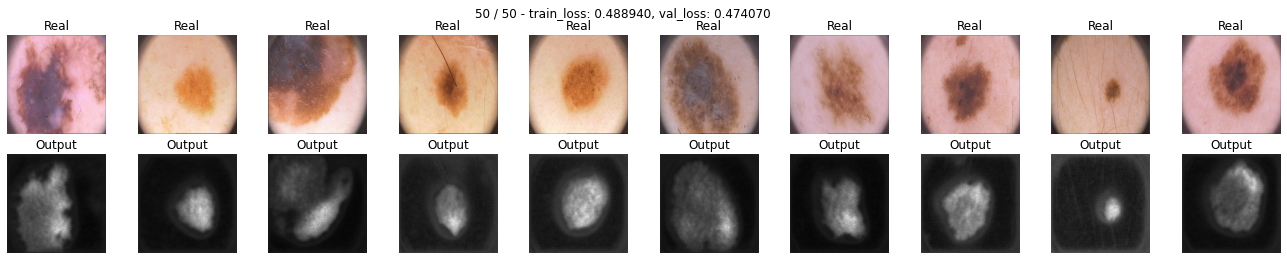

In [ ]:
max_epochs = 50
optimizer = torch.optim.AdamW(model_focal.parameters(), lr=3e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.1)
model_focal, segnet_focal_train, segnet_focal_val = train(model_focal, optimizer, focal_loss, max_epochs, data_tr, data_val, scheduler)

In [ ]:
score_model(model_focal, iou_pytorch, data_val)

0.6700000524520874

In [ ]:
score_model(model_focal, iou_pytorch, data_ts)

0.5580000102519989

In [ ]:
test_score['segnet_focal_val'] = score_model(model_focal, iou_pytorch, data_val)
test_score['segnet_focal_test'] = score_model(model_focal, iou_pytorch, data_ts)
test_score.keys()

dict_keys(['segnet_bce_val', 'segnet_bce_test', 'segnet_dice_val', 'segnet_dice_test', 'segnet_focal_val', 'segnet_focal_test'])

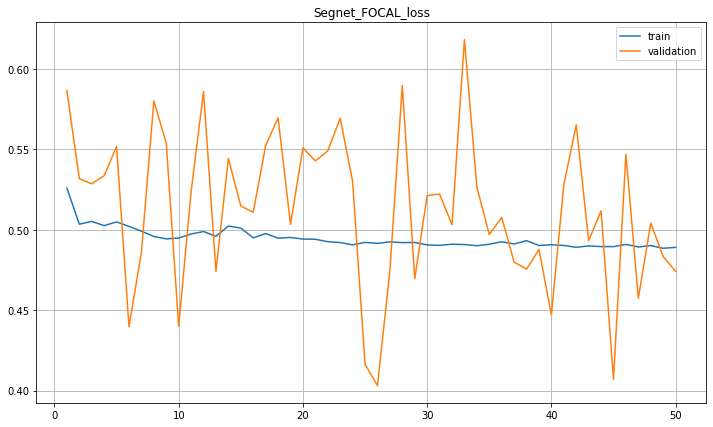

In [ ]:
plt.figure(figsize=(12,7))
plt.plot(range(1, 51), segnet_focal_train, label='train')
plt.plot(range(1, 51), segnet_focal_val, label='validation')
plt.grid()
plt.title('Segnet_FOCAL_loss')
plt.legend()
plt.show()

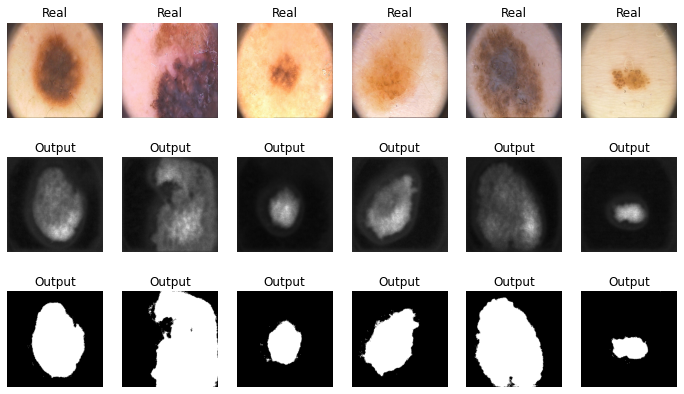

In [ ]:
X_val, Y_val = next(iter(data_val))
model_focal.to('cpu')

model_focal.eval()  # testing mode
Y_pred = model_focal(X_val)
Y_hat = Y_pred.detach().to('cpu') # detached and put into cpu

# Visualize tools
clear_output(wait=True)
plt.figure(figsize=(12,7))
for k in range(6):
    plt.subplot(3, 6, k+1) 
    plt.imshow(np.rollaxis(X_val[k].numpy(), 0, 3), cmap='gray')
    plt.title('Real')
    plt.axis('off')

    plt.subplot(3, 6, k+7)
    plt.imshow(Y_hat[k, 0], cmap='gray')
    plt.title('Output')
    plt.axis('off')

    plt.subplot(3, 6, k+13)
    plt.imshow(torch.sigmoid(Y_hat[k, 0]) > 0.5, cmap='gray')
    plt.title('Output')
    plt.axis('off')

plt.show()

In [ ]:
checkpoint['segnet_focal_train'] = segnet_focal_train
checkpoint['segnet_focal_val'] = segnet_focal_val
checkpoint.keys()

dict_keys(['segnet_bce_train', 'segnet_bce_val', 'segnet_dice_train', 'segnet_dice_val', 'segnet_focal_train', 'segnet_focal_val'])

In [ ]:
torch.save(checkpoint, 'checkpoint1.pth')
torch.save(test_score, 'test_score1.pth')

-----------------------------------------------------------------------------------------

# U-Net

[**U-Net**](https://arxiv.org/abs/1505.04597) — это архитектура нейронной сети, которая получает изображение и выводит его. Первоначально он был задуман для семантической сегментации (как мы ее будем использовать), но он настолько успешен, что с тех пор используется в других контекстах. Получая на вход медицинское изображение, он выведет изображение в оттенках серого, где интенсивность каждого пикселя зависит от вероятности того, что этот пиксель принадлежит интересующей нас области.

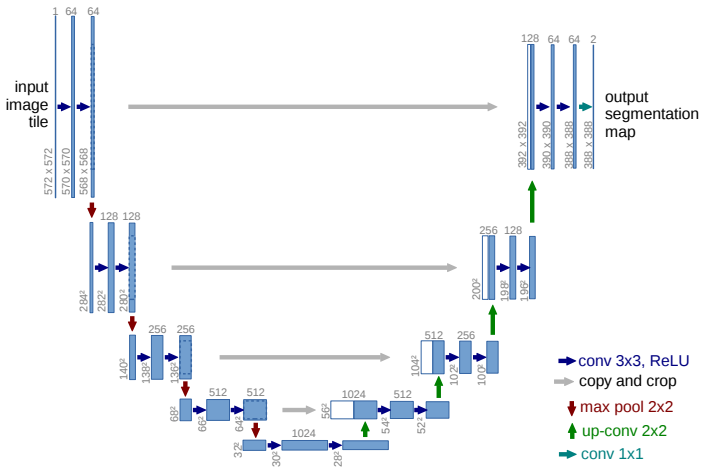

In [ ]:
class UNet(nn.Module):
    def __init__(self):
        super().__init__()

        # encoder (downsampling)
        # Each enc_conv/dec_conv block should look like this:
        # nn.Sequential(
        #     nn.Conv2d(...),
        #     ... (2 or 3 conv layers with relu and batchnorm),
        # )
        self.enc_conv0 = nn.Sequential(nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
                                       nn.ReLU(),
                                       nn.BatchNorm2d(64),
                                       nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
                                       nn.ReLU(),
                                       nn.BatchNorm2d(64)                                       
        )

        self.pool0 = nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True) # 256 -> 128

        self.enc_conv1 = nn.Sequential(nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
                                       nn.ReLU(),
                                       nn.BatchNorm2d(128),
                                       nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
                                       nn.ReLU(),
                                       nn.BatchNorm2d(128)
        )

        self.pool1 =  nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True) # 128 -> 64

        self.enc_conv2 = nn.Sequential(nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
                                       nn.ReLU(),
                                       nn.BatchNorm2d(256),
                                       nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
                                       nn.ReLU(),
                                       nn.BatchNorm2d(256),
                                       nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
                                       nn.ReLU(),
                                       nn.BatchNorm2d(256)
        )

        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True) # 64 -> 32

        self.enc_conv3 = nn.Sequential(nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
                                       nn.ReLU(),
                                       nn.BatchNorm2d(512),
                                       nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
                                       nn.ReLU(),
                                       nn.BatchNorm2d(512),
                                       nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
                                       nn.ReLU(),
                                       nn.BatchNorm2d(512)
        )

        self.pool3 =  nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True) # 32 -> 16

        # bottleneck
        self.bottleneck_conv = nn.Sequential(nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
                                             nn.ReLU(),
                                             nn.BatchNorm2d(512),
                                             nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
                                             nn.ReLU(),
                                             nn.BatchNorm2d(512),
                                             nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1)
            
        )

        # decoder (upsampling)
        self.upsample0 = nn.MaxUnpool2d(kernel_size=2, stride=2) # 16 -> 32

        self.dec_conv0 = nn.Sequential(nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
                                       nn.ReLU(),
                                       nn.BatchNorm2d(512),
                                       nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
                                       nn.ReLU(),
                                       nn.BatchNorm2d(512),
                                       nn.Conv2d(512, 256, kernel_size=3, stride=1, padding=1),
                                       nn.ReLU(),
                                       nn.BatchNorm2d(256)
        )

        self.upsample1 = nn.MaxUnpool2d(kernel_size=2, stride=2) # 32 -> 64
                                        
        self.dec_conv1 = nn.Sequential(nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
                                       nn.ReLU(),
                                       nn.BatchNorm2d(256),
                                       nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
                                       nn.ReLU(),
                                       nn.BatchNorm2d(256),
                                       nn.Conv2d(256, 128, kernel_size=3, stride=1, padding=1),
                                       nn.ReLU(),
                                       nn.BatchNorm2d(128)
        )


        self.upsample2 = nn.MaxUnpool2d(kernel_size=2, stride=2)  # 64 -> 128
                                        
        self.dec_conv2 = nn.Sequential(nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
                                       nn.ReLU(),
                                       nn.BatchNorm2d(128),
                                       nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
                                       nn.ReLU(),
                                       nn.BatchNorm2d(128),
                                       nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1),
                                       nn.ReLU(),
                                       nn.BatchNorm2d(64)
        )


        self.upsample3 =  nn.MaxUnpool2d(kernel_size=2, stride=2) # 128 -> 256

        self.dec_conv3 = nn.Sequential(nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
                                       nn.ReLU(),
                                       nn.BatchNorm2d(64),
                                       nn.Conv2d(64, 1, kernel_size=3, stride=1, padding=1)                                    
        )

    def forward(self, x):
        # encoder
        e0 = self.enc_conv0(x)
        e0_, indices0 = self.pool0(e0)        
        e1 = self.enc_conv1(e0_)
        e1_, indices1 = self.pool1(e1)
        e2 = self.enc_conv2(e1_)
        e2_, indices2 = self.pool2(e2)
        e3 = self.enc_conv3(e2_)
        e3_, indices3 = self.pool3(e3)
        
        # bottleneck
        b = self.bottleneck_conv(e3_)

        # decoder
        d0 = self.upsample0(b, indices3) + e3
        d0 = self.dec_conv0(d0)
        d1 = self.upsample1(d0, indices2) + e2
        d1 = self.dec_conv1(d1)
        d2 = self.upsample2(d1, indices1) + e1
        d2 = self.dec_conv2(d2)
        d3 = self.upsample3(d2, indices0) + e0
        d3 = self.dec_conv3(d3)  # no activation
        return d3

In [ ]:
unet_model_bce = UNet().to(device)

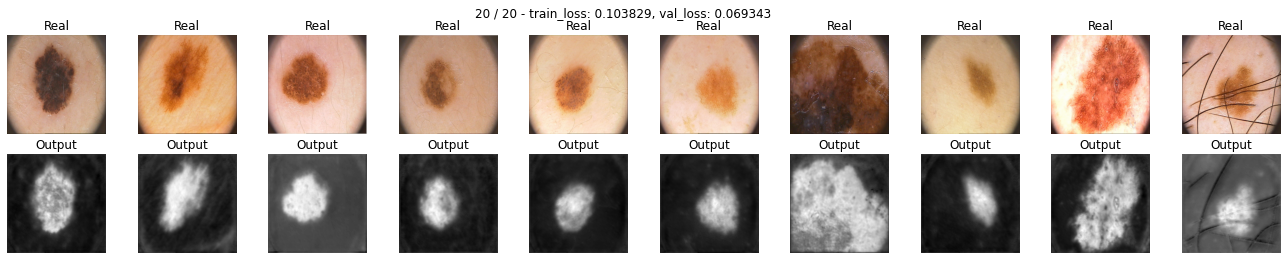

In [ ]:
optimizer = optim.AdamW(unet_model_bce.parameters(), lr=3e-6)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.1)
unet_model_bce, unet_bce_train, unet_bce_val = train(unet_model_bce, optimizer, bce_loss, 20, data_tr, data_val, scheduler)

In [ ]:
score_model(unet_model_bce, iou_pytorch, data_val)

0.7620000123977662

In [ ]:
score_model(unet_model_bce, iou_pytorch, data_ts)

0.7580000162124634

In [ ]:
test_score['unet_bce_val'] = score_model(unet_model_bce, iou_pytorch, data_val)
test_score['unet_bce_test'] = score_model(unet_model_bce, iou_pytorch, data_ts)
test_score.keys()

dict_keys(['segnet_bce_val', 'segnet_bce_test', 'segnet_dice_val', 'segnet_dice_test', 'segnet_focal_val', 'segnet_focal_test', 'unet_bce_val', 'unet_bce_test'])

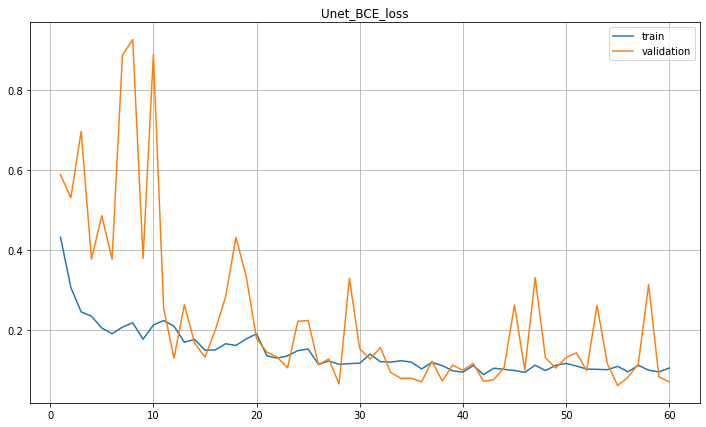

In [ ]:
plt.figure(figsize=(12,7))
plt.plot(range(1, 61), checkpoint['unet_bce_train'], label='train')
plt.plot(range(1, 61), checkpoint['unet_bce_val'], label='validation')
plt.grid()
plt.title('Unet_BCE_loss')
plt.legend()
plt.show()

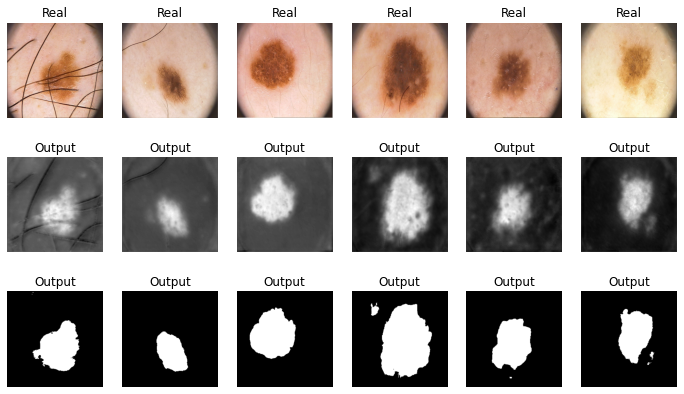

In [ ]:
X_val, Y_val = next(iter(data_val))
unet_model_bce.to('cpu')

unet_model_bce.eval()  # testing mode
Y_pred = unet_model_bce(X_val)
Y_hat = Y_pred.detach().to('cpu') # detach and put into cpu

# Visualize tools
clear_output(wait=True)
plt.figure(figsize=(12,7))
for k in range(6):
    plt.subplot(3, 6, k+1) 
    plt.imshow(np.rollaxis(X_val[k].numpy(), 0, 3), cmap='gray')
    plt.title('Real')
    plt.axis('off')

    plt.subplot(3, 6, k+7)
    plt.imshow(Y_hat[k, 0], cmap='gray')
    plt.title('Output')
    plt.axis('off')

    plt.subplot(3, 6, k+13)
    plt.imshow(torch.sigmoid(Y_hat[k, 0]) > 0.5, cmap='gray')
    plt.title('Output')
    plt.axis('off')

plt.show()

In [ ]:
checkpoint['unet_bce_train'] += unet_bce_train
checkpoint['unet_bce_val'] += unet_bce_val
checkpoint.keys()

dict_keys(['segnet_bce_train', 'segnet_bce_val', 'segnet_dice_train', 'segnet_dice_val', 'segnet_focal_train', 'segnet_focal_val', 'unet_bce_train', 'unet_bce_val'])

In [ ]:
unet_model_dice = UNet().to(device)

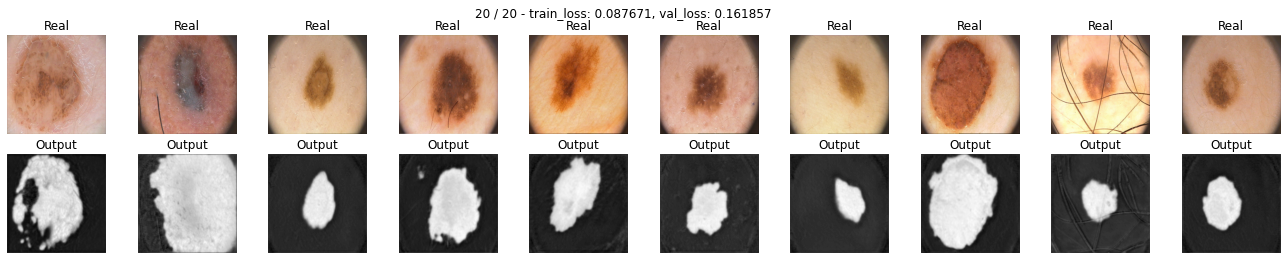

In [ ]:
optimizer = optim.AdamW(unet_model_dice.parameters(), lr=3e-7)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.1)
unet_model_dice, unet_dice_train, unet_dice_val = train(unet_model_dice, optimizer, dice_loss, 20, data_tr, data_val, scheduler)

In [ ]:
score_model(unet_model_dice, iou_pytorch, data_val)

0.7320000052452087

In [ ]:
score_model(unet_model_dice, iou_pytorch, data_ts)

0.7220000386238098

In [ ]:
test_score['unet_dice_val'] = score_model(unet_model_dice, iou_pytorch, data_val)
test_score['unet_dice_test'] = score_model(unet_model_dice, iou_pytorch, data_ts)
test_score.keys()

dict_keys(['segnet_bce_val', 'segnet_bce_test', 'segnet_dice_val', 'segnet_dice_test', 'segnet_focal_val', 'segnet_focal_test', 'unet_bce_val', 'unet_bce_test', 'unet_dice_val', 'unet_dice_test'])

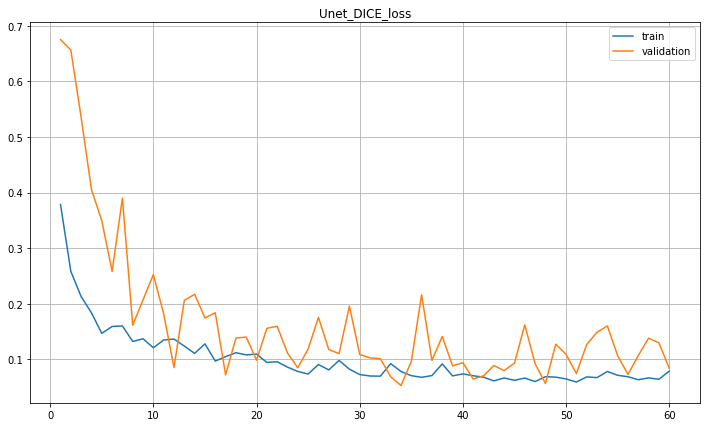

In [ ]:
plt.figure(figsize=(12,7))
plt.plot(range(1, 61), unet_dice_train, label='train')
plt.plot(range(1, 61), unet_dice_val, label='validation')
plt.grid()
plt.title('Unet_DICE_loss')
plt.legend()
plt.show()

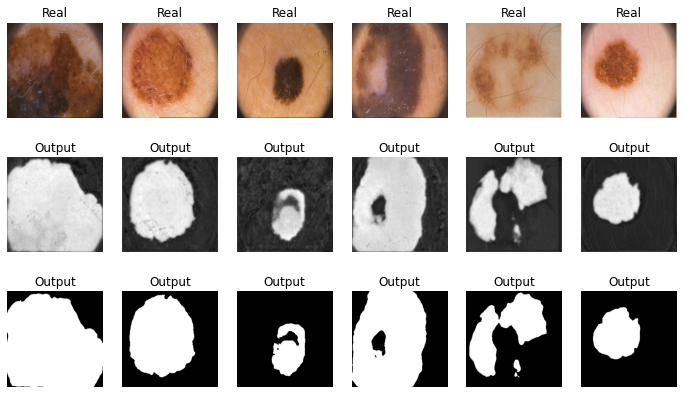

In [ ]:
X_val, Y_val = next(iter(data_val))
unet_model_dice.to('cpu')

unet_model_dice.eval()  # testing mode
Y_pred = unet_model_dice(X_val)
Y_hat = Y_pred.detach().to('cpu') # detach and put into cpu

# Visualize tools
clear_output(wait=True)
plt.figure(figsize=(12,7))
for k in range(6):
    plt.subplot(3, 6, k+1) 
    plt.imshow(np.rollaxis(X_val[k].numpy(), 0, 3), cmap='gray')
    plt.title('Real')
    plt.axis('off')

    plt.subplot(3, 6, k+7)
    plt.imshow(Y_hat[k, 0], cmap='gray')
    plt.title('Output')
    plt.axis('off')

    plt.subplot(3, 6, k+13)
    plt.imshow(torch.sigmoid(Y_hat[k, 0]) > 0.5, cmap='gray')
    plt.title('Output')
    plt.axis('off')

plt.show()

In [ ]:
checkpoint['unet_dice_train'] = unet_dice_train
checkpoint['unet_dice_val'] = unet_dice_val
checkpoint.keys()

dict_keys(['segnet_bce_train', 'segnet_bce_val', 'segnet_dice_train', 'segnet_dice_val', 'segnet_focal_train', 'segnet_focal_val', 'unet_bce_train', 'unet_bce_val', 'unet_dice_train', 'unet_dice_val'])

In [ ]:
unet_model_focal = UNet().to(device)

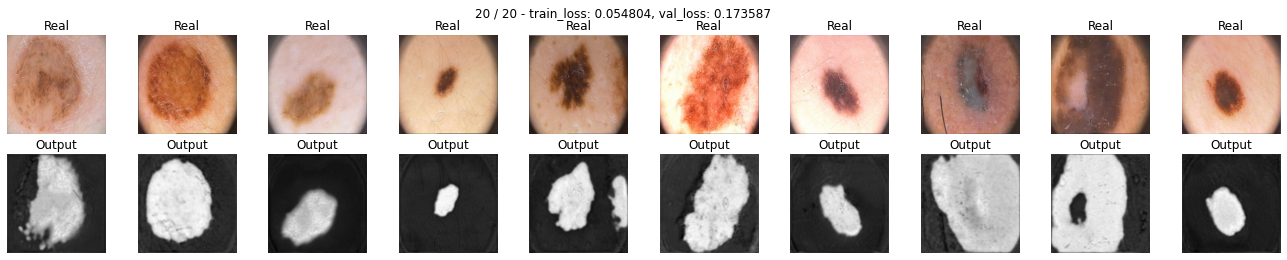

In [ ]:
optimizer = optim.AdamW(unet_model_focal.parameters(), lr=3e-7)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.1)
unet_model_focal, unet_focal_train, unet_focal_val = train(unet_model_focal, optimizer, dice_loss, 20, data_tr, data_val, scheduler)

In [ ]:
score_model(unet_model_focal, iou_pytorch, data_val)

0.7140000104904175

In [ ]:
score_model(unet_model_focal, iou_pytorch, data_ts)

0.7140000343322754

In [ ]:
test_score['unet_focal_val'] = score_model(unet_model_focal, iou_pytorch, data_val)
test_score['unet_focal_test'] = score_model(unet_model_focal, iou_pytorch, data_ts)
test_score.keys()

dict_keys(['segnet_bce_val', 'segnet_bce_test', 'segnet_dice_val', 'segnet_dice_test', 'segnet_focal_val', 'segnet_focal_test', 'unet_bce_val', 'unet_bce_test', 'unet_dice_val', 'unet_dice_test', 'unet_focal_val', 'unet_focal_test'])

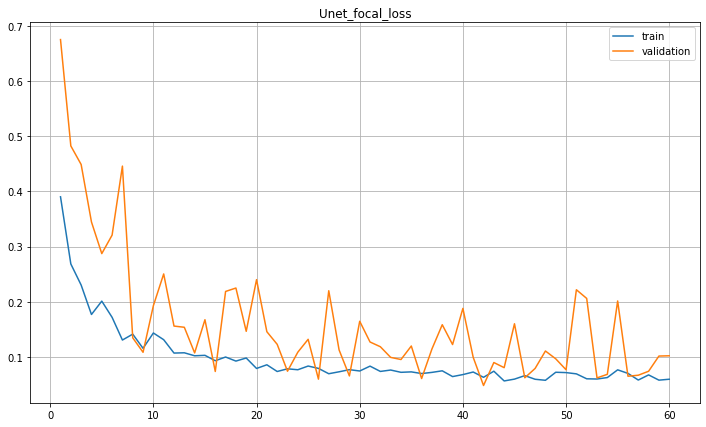

In [ ]:
plt.figure(figsize=(12,7))
plt.plot(range(1, 61), unet_focal_train, label='train')
plt.plot(range(1, 61), unet_focal_val, label='validation')
plt.grid()
plt.title('Unet_focal_loss')
plt.legend()
plt.show()

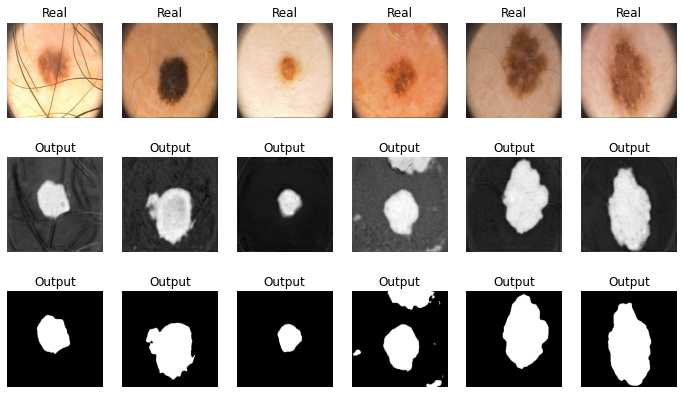

In [ ]:
X_val, Y_val = next(iter(data_val))
unet_model_focal.to('cpu')

unet_model_focal.eval()  # testing mode
Y_pred = unet_model_focal(X_val)
Y_hat = Y_pred.detach().to('cpu') # detached and put into cpu

# Visualize tools
clear_output(wait=True)
plt.figure(figsize=(12,7))
for k in range(6):
    plt.subplot(3, 6, k+1) 
    plt.imshow(np.rollaxis(X_val[k].numpy(), 0, 3), cmap='gray')
    plt.title('Real')
    plt.axis('off')

    plt.subplot(3, 6, k+7)
    plt.imshow(Y_hat[k, 0], cmap='gray')
    plt.title('Output')
    plt.axis('off')

    plt.subplot(3, 6, k+13)
    plt.imshow(torch.sigmoid(Y_hat[k, 0]) > 0.5, cmap='gray')
    plt.title('Output')
    plt.axis('off')

plt.show()

In [ ]:
checkpoint['unet_focal_train'] = unet_focal_train
checkpoint['unet_focal_val'] = unet_focal_val
checkpoint.keys()

dict_keys(['segnet_bce_train', 'segnet_bce_val', 'segnet_dice_train', 'segnet_dice_val', 'segnet_focal_train', 'segnet_focal_val', 'unet_bce_train', 'unet_bce_val', 'unet_dice_train', 'unet_dice_val', 'unet_focal_train', 'unet_focal_val'])

In [ ]:
torch.save(checkpoint, 'checkpoint2.pth')
torch.save(test_score, 'test_score2.pth')

In [ ]:
checkpoint = torch.load('./checkpoint2.pth')
test_score = torch.load('./test_score2.pth')

**Отчет**

Были реализованы две архитектуры глубокого обучения для семантической сегментации изображений: SegNet и UNet - каждая из моделей была обучена на датасете ADDI project с тремя различными функциями потерь: BCE-loss, DICE-loss и FOCAL-loss, соответственно. 

Задача представленной работы была в нахождении архитектуры и функции потерь с наилучшими результатами на тестовой выборке. Ожидалось, что архитектура UNet покажет значительное опережение архитектуры SegNet на используемых метриках.

Результаты работы представлены ниже.

In [125]:
plt.rcParams.update({'font.size': 14})

Сравнение лоссов на трейне, Segnet:

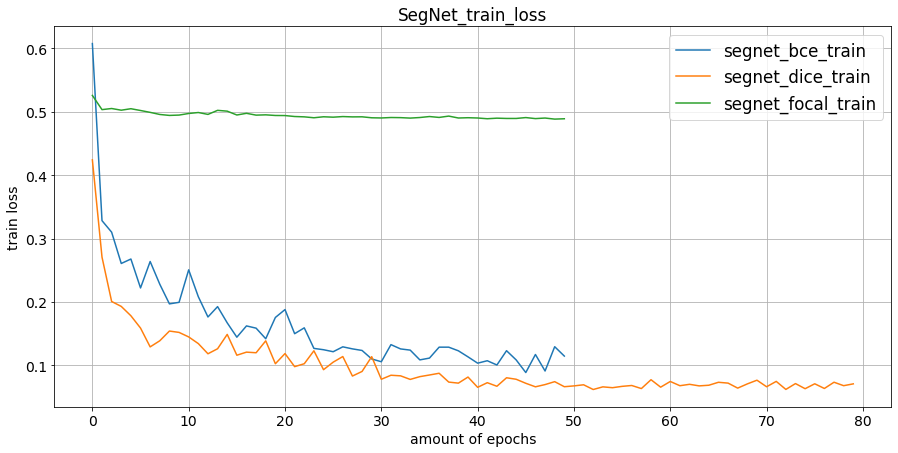

In [126]:
plt.figure(figsize=(15, 7))
plt.plot(checkpoint['segnet_bce_train'], label='segnet_bce_train')
plt.plot(checkpoint['segnet_dice_train'], label='segnet_dice_train')
plt.plot(checkpoint['segnet_focal_train'], label='segnet_focal_train')
plt.title('SegNet_train_loss')
plt.xlabel('amount of epochs')
plt.ylabel('train loss')
plt.grid()
plt.legend()
plt.show()

Сравнение лоссов на валидации, Segnet:

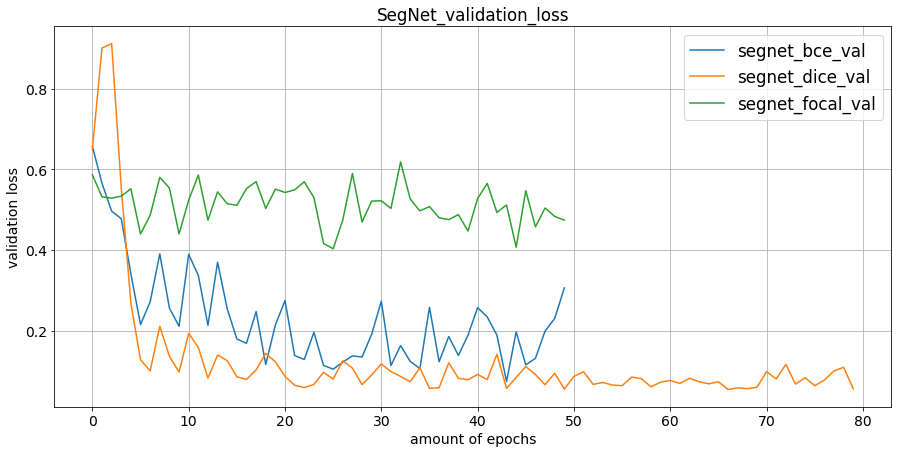

In [127]:
plt.figure(figsize=(15,7))
plt.plot(checkpoint['segnet_bce_val'], label='segnet_bce_val')
plt.plot(checkpoint['segnet_dice_val'], label='segnet_dice_val')
plt.plot(checkpoint['segnet_focal_val'], label='segnet_focal_val')
plt.title('SegNet_validation_loss')
plt.xlabel('amount of epochs')
plt.ylabel('validation loss')
plt.grid()
plt.legend()
plt.show()

Метрики модели на каждом лоссе:



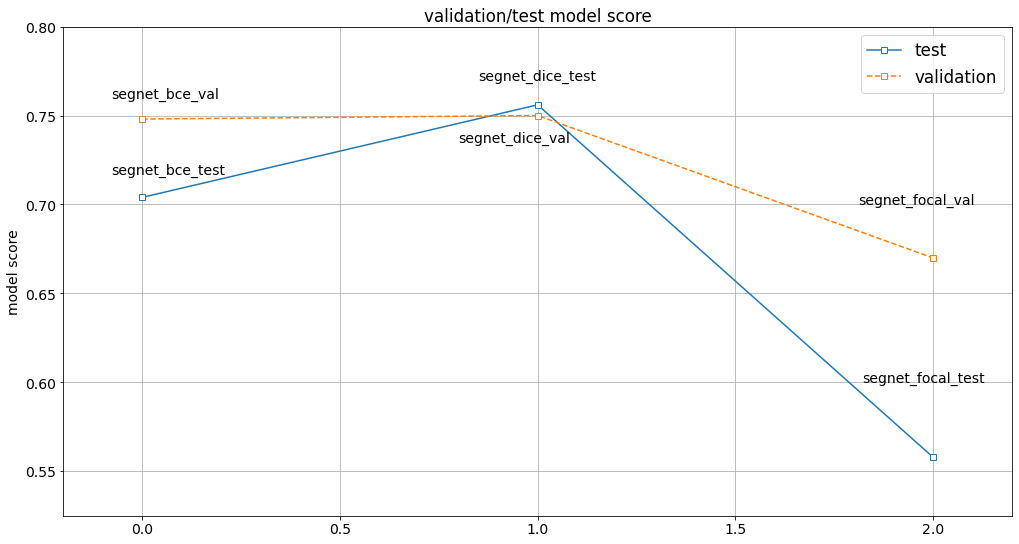

In [150]:
fig = plt.figure(figsize=(17,9))
ax = fig.add_subplot()
ax.plot([test_score['segnet_bce_test'], test_score['segnet_dice_test'], test_score['segnet_focal_test']], '-s', markerfacecolor='w', label='test')
ax.plot([test_score['segnet_bce_val'], test_score['segnet_dice_val'], test_score['segnet_focal_val']], '--s', markerfacecolor='w', label='validation')
ax.annotate('segnet_bce_test', xy=(0, test_score['segnet_bce_test']), xytext=(-0.08, 0.717))
ax.annotate('segnet_bce_val', xy=(0, test_score['segnet_bce_val']), xytext=(-0.08, 0.76))
ax.annotate('segnet_dice_test', xy=(1, test_score['segnet_dice_test']), xytext=(0.85, 0.770))
ax.annotate('segnet_dice_val', xy=(1, test_score['segnet_dice_val']), xytext=(0.8, 0.735))
ax.annotate('segnet_focal_test', xy=(2, test_score['segnet_focal_test']), xytext=(1.82, 0.6))
ax.annotate('segnet_focal_val', xy=(2, test_score['segnet_focal_val']), xytext=(1.81, 0.7))
ax.set_ylim(0.525, 0.8)
ax.set_xlim(-0.2, 2.2)
ax.set_title('validation/test model score')
ax.set_ylabel('model score')
ax.legend()
ax.grid()
plt.show()

По результатам, наилучшие показатели на тесте, как и наименьшие значения лоссов на трейне и валидации (при максимальном количестве эпох до наступления переобучения модели), наблюдаются у SegNet с DICE-лоссом.

Сравнение лоссов на трейне, UNet:

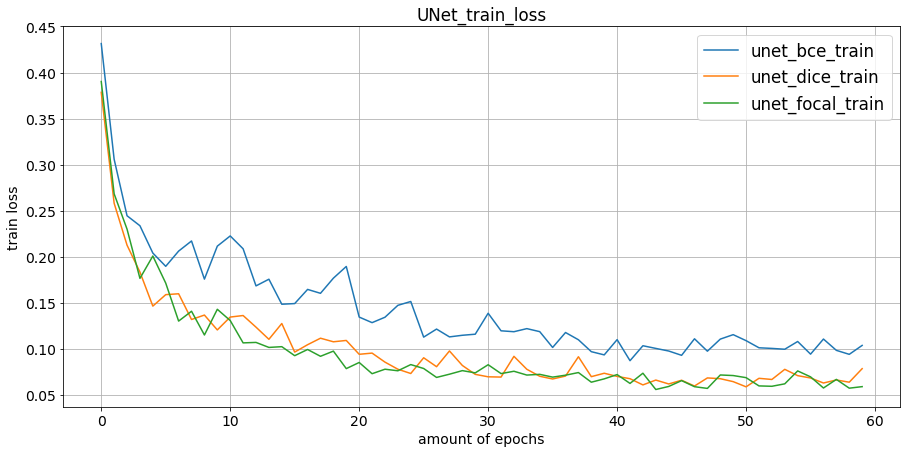

In [144]:
plt.figure(figsize=(15,7))
plt.plot(checkpoint['unet_bce_train'], label='unet_bce_train')
plt.plot(checkpoint['unet_dice_train'], label='unet_dice_train')
plt.plot(checkpoint['unet_focal_train'], label='unet_focal_train')
plt.title('UNet_train_loss')
plt.xlabel('amount of epochs')
plt.ylabel('train loss')
plt.grid()
plt.legend()
plt.show()

Сравнение лоссов на валидации, UNet:

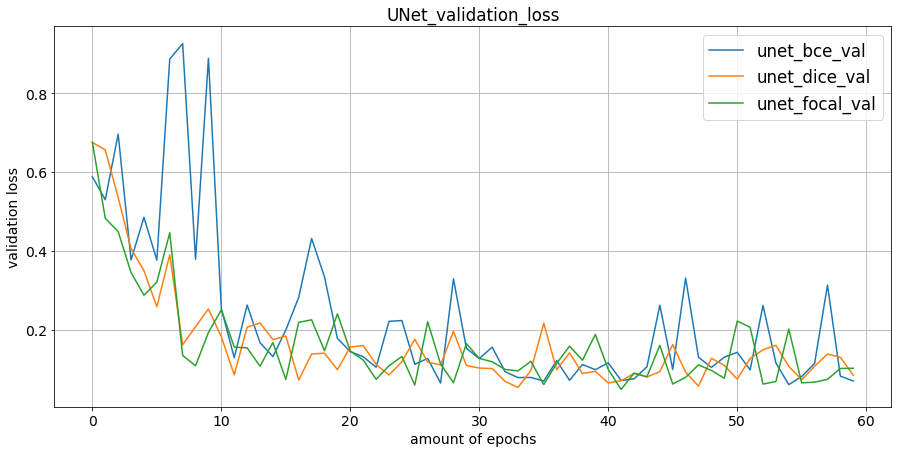

In [145]:
plt.figure(figsize=(15,7))
plt.plot(checkpoint['unet_bce_val'], label='unet_bce_val')
plt.plot(checkpoint['unet_dice_val'], label='unet_dice_val')
plt.plot(checkpoint['unet_focal_val'], label='unet_focal_val')
plt.title('UNet_validation_loss')
plt.xlabel('amount of epochs')
plt.ylabel('validation loss')
plt.grid()
plt.legend()
plt.show()

Метрики модели на каждом лоссе:

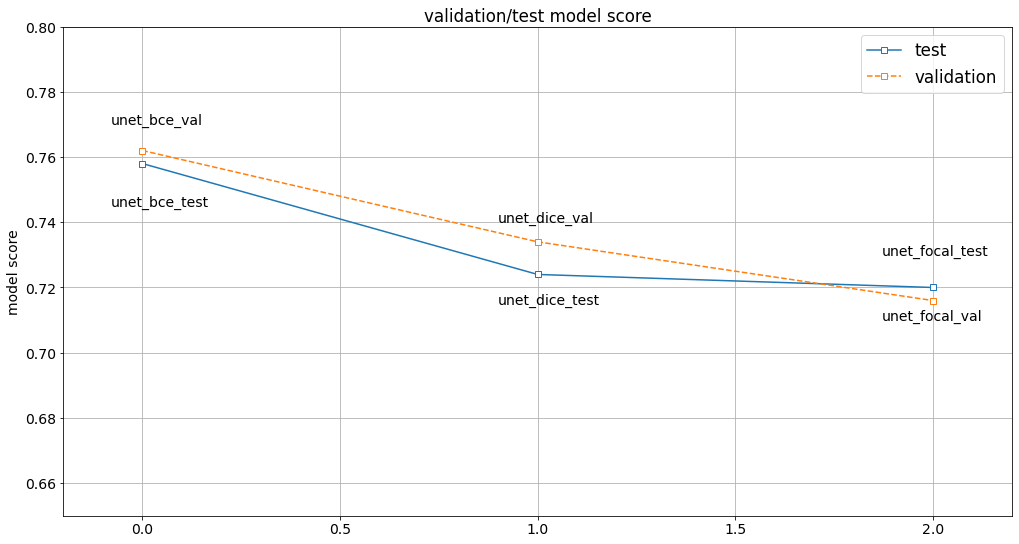

In [146]:
fig = plt.figure(figsize=(17, 9))
ax = fig.add_subplot()
ax.plot([test_score['unet_bce_test'], test_score['unet_dice_test'], test_score['unet_focal_test']], '-s', markerfacecolor='w', label='test')
ax.plot([test_score['unet_bce_val'], test_score['unet_dice_val'], test_score['unet_focal_val']], '--s', markerfacecolor='w', label='validation')
ax.annotate('unet_bce_test', xy=(0, test_score['unet_bce_test']), xytext=(-0.08, 0.745))
ax.annotate('unet_bce_val', xy=(0, test_score['unet_bce_val']), xytext=(-0.08, 0.77))
ax.annotate('unet_dice_test', xy=(1, test_score['unet_dice_test']), xytext=(0.9, 0.715))
ax.annotate('unet_dice_val', xy=(1, test_score['unet_dice_val']), xytext=(0.9, 0.74))
ax.annotate('unet_focal_test', xy=(2, test_score['unet_focal_test']), xytext=(1.87, 0.73))
ax.annotate('unet_focal_val', xy=(2, test_score['unet_focal_val']), xytext=(1.87, 0.71))
ax.set_ylim(0.65, 0.8)
ax.set_xlim(-0.2, 2.2)
ax.set_title('validation/test model score')
ax.set_ylabel('model score')
ax.legend()
ax.grid()
plt.show()

Для UNet значения лоссов на трейне/валидации не так сильно отличаются друг от друга, однако значения метрики на тесте однозначно показывают, что лучшее качество достигнуто с BCE-лоссом.

Сравнение лучших показателей на моделях UNet и SegNet:

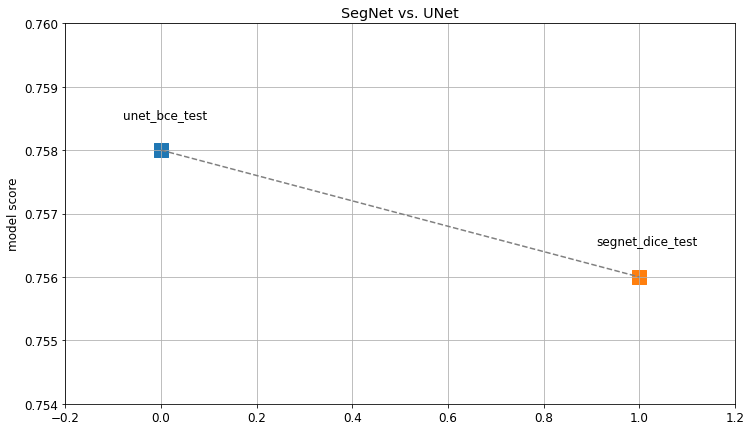

In [112]:
fig = plt.figure(figsize=(12, 7))
ax = fig.add_subplot()
ax.plot([test_score['unet_bce_test'], test_score['segnet_dice_test']], '--', color='#808080', label='test')
ax.scatter(0, test_score['unet_bce_test'], marker='s', s=205)
ax.scatter(1, test_score['segnet_dice_test'], marker='s', s=205)
ax.annotate('unet_bce_test', xy=(0, test_score['unet_bce_test']), xytext=(-0.08, 0.7585))
ax.annotate('segnet_dice_test', xy=(0, test_score['segnet_dice_test']), xytext=(0.91, 0.7565))

ax.set_ylim(0.754, 0.76)
ax.set_xlim(-0.2, 1.2)
ax.set_title('SegNet vs. UNet')
ax.set_ylabel('model score')

ax.grid()

plt.show()

**Вывод**

Модель UNet с BCE-лоссом показала наилучшие результаты на тестовой выборке, однако значительное опережение данной архитектуры по качеству на метриках в приведенных мной результатах на данный момент не подтвердилось. Лучшие результаты на UNet опережают лучшие результаты на SegNet всего на 0.002 (0.758 против 0.756, сответственно), что нельзя назвать значительным опережением по качеству.